<div align="right" style="text-align: right"><i>Peter Norvig<br>July 2021</i></div>

# Olympic Climbing Wall

From the 538 Riddler on [23 July 2021](https://fivethirtyeight.com/features/can-you-hop-across-the-chessboard/) (rephrased):

>Today marks the beginning of the Summer Olympics! One of the brand-new events this year is [sport climbing](https://olympics.com/tokyo-2020/en/sports/sport-climbing/).
>
>Suppose the organizers place climbing holds uniformly at randomly on a 10-by-10 meter climbing wall until there is a **path**: a series of moves from the bottom of the wall to a hold, and then to successive holds, and finally to the top of the wall, where each move is no more than 1 meter distance. There are two climbing events:
> - For the first event, all the holds are placed at random heights on a single vertical line. 
> - For the second event, holds are placed at random anywhere on the wall. 
>
> On average, how many holds (not including the bottom and top of the wall) have to be placed to make a path in each event?

# First Event

A hold can be represented by a single number, the vertical height off the ground. I'll define `place_holds` to randomly place holds until a path is formed (as detected by `is_path`). Internally to the function, the bottom and top of the wall are considered to be holds, but these are excluded from the output of the function.

In [1]:
import random
from typing import List, Tuple, Iterable
from statistics import mean

def place_holds(top=10) -> List[float]:
    """Randomly place holds on wall until there is a path from bottom to top."""
    holds = [0, top]
    while not is_path(holds):
        holds.append(random.uniform(0, top))
        holds.sort()
    return holds[1:-1] # (not including the bottom and top of the wall)
        
def is_path(holds) -> bool:
    """Do the sorted holds form a path where each move has distance <= 1?"""
    return all(holds[i + 1] - holds[i] <= 1
               for i in range(len(holds) - 1))

For example, here are random holds that form a path on a 3 meter tall wall:

In [2]:
place_holds(3)

[0.845553458582284, 1.384891681206423, 2.2900550596027087, 2.484136525301279]

I can use a [Monte Carlo algorithm](https://en.wikipedia.org/wiki/Monte_Carlo_algorithm) to estimate the expected number of holds by averaging the `len` of  repetitions of  `place_holds`:

In [3]:
def monte_carlo(fn, *args, repeat=50_000, key=len) -> float:
    """Mean value of `repeat` repetitions of key(fn(*args))."""
    return mean(key(fn(*args)) for _ in range(repeat))

In [4]:
monte_carlo(place_holds)

43.03982

**Answer: The expected number of holds is about 43** (which I found surprisingly large).

# Second Event

For this event a hold is represented by a point in 2-D space: an `(x, y)` tuple of two numbers:

In [5]:
Hold = Point = Tuple[float, float]
def X_(point): return point[0]
def Y_(point): return point[1]

def distance(A: Point, B: Point) -> float: 
    """Distance between two 2-D points."""
    return abs(complex(*A) - complex(*B))

To make it easier to determine when there is a path from bottom to top, I'll keep track, for every hold, of the highest hold that can be reached from that hold (in any number of moves). The data structure `Wall` will be a mapping of `{hold: highest_reachable_hold}`. A `Wall` also has an attribute, `wall.paths`, that is a dict whose entries are `{hold_near_bottom: hold_near_top}` pairs denoting paths from bottom to top.

When a new `hold` is added to the wall, update the wall as follows: 
- Find all holds that are within 1 meter of the new `hold` (including the `hold` itself).
- For each of those holds, look up the highest hold they can reach. That set of holds is called `reachable_holds`.
- The highest of the reachable holds is called `highest_hold`.
- Any hold that can reach one of `reachable_holds` can reach all of them (via `hold`), and thus can reach `highest_hold`.
- So update each such hold to say that it can reach `highest_hold`.
- Also, if `highest_hold` is within a meter of the top, and a hold `h` that can reach it is within a meter of the bottom, update the `paths` attribute to include the path `{h: highest_hold}`.

In [6]:
class Wall(dict):
    """A Wall is a mapping of {hold: highest_reachable_hold}.
    Also keep track of `wall.paths`: a map of {start_hold: end_hold}
    where there is a path from start to end, and start is within 1 
    of the bottom, and end is within 1 of the top."""
    def __init__(self, top=10): 
        self.top = top
        self.paths = {} # Paths of the form {hold_near_bottom: hold_near_top}
    
    def add(self, hold: Point):
        """Add hold to this Wall, and merge groups of holds."""
        self[hold] = hold # A hold can at least reach itself
        self.merge({self[h] for h in self if distance(hold, h) <= 1})

    def merge(self, reachable_holds):
        """If you can reach one of these holds, you can reach the highest of them."""
        if len(reachable_holds) > 1:
            highest_hold = max(reachable_holds, key=Y_)
            for h in self:
                if self[h] in reachable_holds:
                    self[h] = highest_hold
                    if Y_(h) <= 1 and self.top - Y_(highest_hold) <= 1:
                        self.paths[h] = highest_hold

*Note: This could be made more efficient with an [integer lattice](https://en.wikipedia.org/wiki/Fixed-radius_near_neighbors) to quickly find holds within 1 meter, and a [union-find forest](https://en.wikipedia.org/wiki/Disjoint-set_data_structure) to quickly merge groups of holds. But since the expected number of points is small, I opted for simplicity, not efficiency.*

Now `place_holds_2d` is analagous to `place_holds`, but places holds in two dimensions:

In [7]:
def place_holds_2d(top=10) -> Wall:
    """Randomly place holds on a square wall until there is a path from bottom to top."""
    wall = Wall(top)
    while not wall.paths:
        wall.add((random.uniform(0, top), random.uniform(0, top)))
    return wall

Finally, we can estimate the expected number of holds:

In [8]:
monte_carlo(place_holds_2d, repeat=5000)

143.2666

**Answer: The expected number of holds is about 143** (which I found surprisingly small).

# Visualization

To get an idea what random climbing walls look like, and to gain confidence in this program, I'll plot some climbing walls, with green dots indicating the random climbing holds, and yellow lines indicating possible paths from bottom to top.

In [9]:
import matplotlib.pyplot as plt

def plot_wall(wall):
    """Plot the holds on the wall, and the paths from bottom to top."""
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(0, wall.top); plt.ylim(0, wall.top)
    ends = set(wall.paths.values())
    for h in wall:
        if wall[h] in ends:
            if Y_(h) <= 1: # Plot vertical move from bottom
                plot_points([h, (X_(h), 0)], 'y-')
            if wall.top - Y_(h) <= 1: # Plot vertical move to top
                plot_points([h, (X_(h), wall.top)], 'y-')
            for h2 in wall:
                if distance(h, h2) <= 1:
                    plot_points([h, h2], 'y-') # Plot move between holds
    plot_points(wall, 'g.') # Plot all holds
    plt.title(f'holds: {len(wall)}     starts: {len(wall.paths)}')

def plot_points(points, fmt):
    """Plot (x, y) points with given format."""
    plt.plot([X_(p) for p in points], [Y_(p) for p in points], fmt)

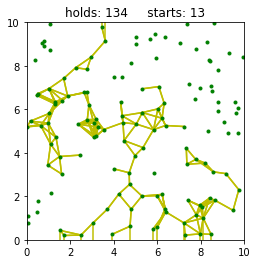

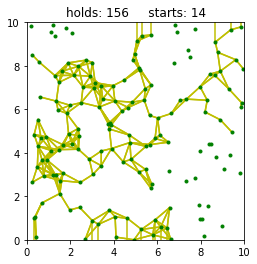

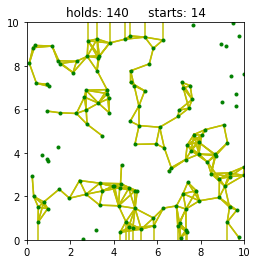

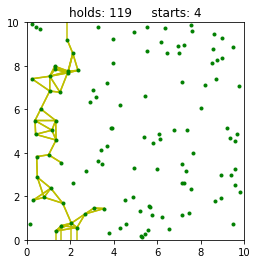

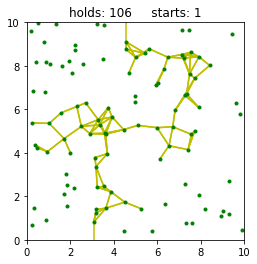

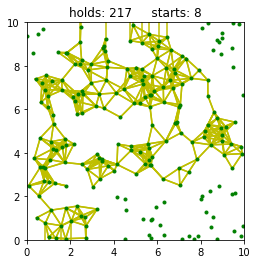

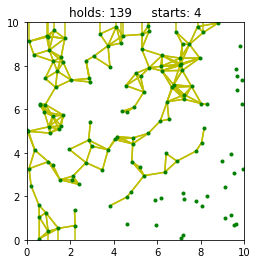

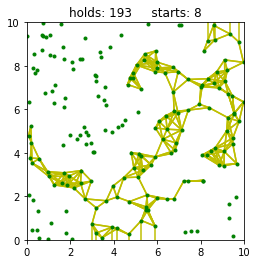

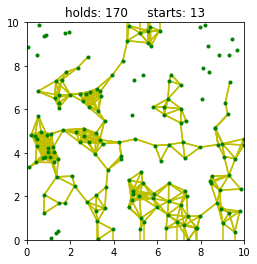

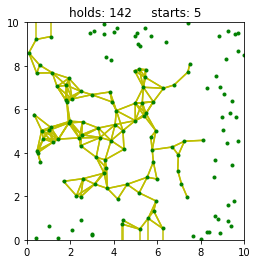

In [10]:
for i in range(10):
    plot_wall(place_holds_2d(10))
    plt.show()

To get a feel for the internals of a `Wall`, let's look at a smaller one:

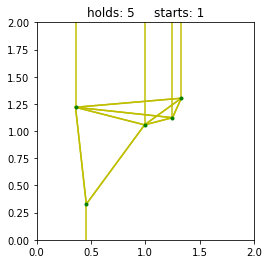

In [19]:
wall = place_holds_2d(2)
plot_wall(wall)

In [20]:
wall

{(0.9934826941579458, 1.0572834992450997): (1.3314849992519568,
  1.3023468539111032),
 (0.3583556329014106, 1.2190468817825952): (1.3314849992519568,
  1.3023468539111032),
 (1.2499181582424967, 1.1234512122002231): (1.3314849992519568,
  1.3023468539111032),
 (1.3314849992519568, 1.3023468539111032): (1.3314849992519568,
  1.3023468539111032),
 (0.45747066866761976, 0.32822934854292884): (1.3314849992519568,
  1.3023468539111032)}

In [21]:
wall.paths

{(0.45747066866761976, 0.32822934854292884): (1.3314849992519568,
  1.3023468539111032)}

# Different Size Walls

What if the wall had a size other than 10 meters? 

My guess would be that the expected number of required holds goes up roughly linearly on the 1-D wall, and roughly quadratically on the 2-D wall. I can plot expected number of holds for different wall heights, and fit a quadratic polynomial to the data (using `np.polyfit` and `np.poly1d`): 

In [14]:
import numpy as np

def fit(X, fn, key=len, repeat=1000, degree=2) -> np.array:
    """Fit key(fn(x)) to a polynomial; plot; return polynomial coefficients."""
    Y = [monte_carlo(fn, x, key=key, repeat=repeat) for x in X]
    coefs = np.polyfit(X, Y, 2)
    poly  = np.poly1d(coefs)
    plt.plot(X, Y, 'o-', label=fn.__name__);
    plt.plot(X, [poly(x) for x in X], '.:', label=poly_name(coefs))
    plt.legend()
    return coefs

def poly_name(coefs, ndigits=2) -> str:
    """A str representing a polynomial."""
    degree = len(coefs) - 1
    return ' + '.join(term(round(coef, ndigits), degree - i) 
                      for i, coef in enumerate(coefs))

def term(coef, d) -> str: 
    """A str representing a term in a polynomial."""
    return f'{coef}' + ('' if d == 0 else 'x' if d == 1 else f'x^{d}')

First 1-D walls—we see the best-fit quadratic is almost a straight line, but has a slight upward bend:

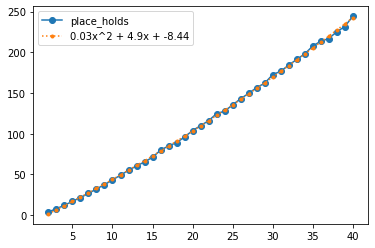

In [15]:
fit(range(2, 41), place_holds);

Now 2-D walls—we see a prominent quadratic shape:

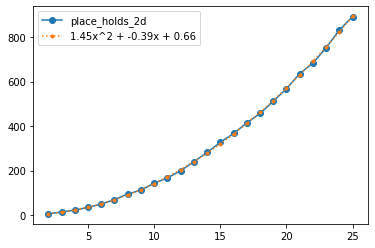

In [16]:
fit(range(2, 26), place_holds_2d, repeat=100);

# Do the Math

The Monte Carlo approach can only give an approximation. To get an exact result requires a level of math that is above my ability. Fortunately, a real mathematician, [George Hauser](https://www.math.rutgers.edu/component/comprofiler/userprofile/gdh43?Itemid=753), provided the following analysis of the first event:
- If you choose uniformly randomly *n* numbers between 0 and 1 and put them in order (including 0 and 1 in the list) and look at the *n*+1 gaps between them, the probability that any given *k* of the gaps are greater than *x* is (1-*kx*)<sup>*n*</sup> if *kx* ≤ 1 and 0 otherwise. So by inclusion-exclusion, the probability that the largest gap is greater than *x* is the sum of the probabilities that each individual gap is greater than *x*, minus the sum of the probabilities that each pair of gaps are simultaneously greater than *x*, plus the sum of all triples, etc. 
- So as a formula it is Pr(*X*<sub>*n*</sub> > *x*) = ∑<sub>*k* ≤ 1/*x*</sub> (-1)<sup>*k*-1</sup> (*n*+1 choose *k*) (1-*kx*)<sup>*n*</sup>.
- Here *X*<sub>*n*</sub> is the largest gap that appears in a sample of *n* random points between 0 and 1. 
- What we are interested in is *N*, the first step at which *X*<sub>*n*</sub> < *x*, and E(*N*) the expectation of *N*. 
- This expectation is ∑<sub>*n* ≥ 1</sub> *n* Pr(*X*<sub>*n*</sub> < *x* and *X*<sub>*n-1*</sub> > *x*). 
- But the sequence *X*<sub>*n*</sub> is decreasing since the biggest gap can only get smaller when you add a new hold. 
- So this series just telescopes into ∑<sub>*n* ≥ 1</sub> Pr(*X*<sub>*n*</sub> > *x*).
- So combining the two formulas we need to evaluate ∑<sub>*n* ≥ 1</sub>∑<sub>*k* ≤ 1/*x*</sub> (-1)<sup>*k*-1</sup> (*n*+1 choose *k*) (1-*kx*)<sup>*n*</sup>. 
- If you sum first over n, this gives ∑<sub>*k* ≤ 1/*x*</sub> (-1)<sup>*k*-1</sup> (*kx*)<sup>-2</sup> (1/(*kx*)-1)<sup>*k* - 1</sup>. 
- I couldn't really simplify this further, but it is easy enough to plug in *x* = 1/10 (i.e. 1 out of 10 meters) and get the answer.

Hauser did the computation with exact rationals and with floating point approximations:

In [42]:
from fractions import Fraction

def hauser(x):
    """George Hauser's formula for the expected number of holds in the first Event."""
    return sum((-1) ** (k - 1) * (k * x) ** -2 * (1 / (k * x) - 1) ** (k - 1)
               for k in range(1, int(1/x) + 1))

print(hauser(Fraction(1, 10)), '≅', hauser(1 / 10))

226824785043461849328151/5269256457858371026944 ≅ 43.046829634792914


This agrees well with my Monte Carlo estimate.